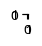

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# Check the "best" model for NOTRIPLET VAEs


In [3]:
def plot_pipeline_here(runs, title=None, fn=None, palette='tab10', add_clustersize=False, 
                       figsize=(9,9), legend=True, outdir = None):
    # plotting options
    sns.set_palette(palette, n_colors=len(runs.input_type.unique()))
    f, a = plt.subplots(1, 1, figsize=figsize)
    a.set_xlim([0, 1])
    a.set_ylim([0, 1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Mean Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    if add_clustersize:
        ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        ax2.set_ylabel('Mean Cluster Size (Log2)', fontweight='semibold', fontsize=14)
    for input_type in runs.input_type.unique():
        query = runs.query('input_type==@input_type')
        retentions = query['retention'][1:-1].values
        purities = query['mean_purity'][1:-1].values
        if add_clustersize:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
            
        if input_type == "TBCRalign":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls=':', c='g', lw=1)
            if add_clustersize:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.25, s=6, c='g')

        elif input_type == "tcrdist3":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls=':', c='m', lw=1)
            if add_clustersize:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='.', lw=0.25, s=6, c='m')

        else:
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='--', lw=1.1)
            if add_clustersize:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.25, s=6)


    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    if legend:
        a.legend(title='distance matrix', title_fontproperties={'size': 14, 'weight': 'semibold'},
             prop={'weight': 'semibold', 'size': 12}, loc='lower left')
    f.suptitle(f'{title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fn is not None:
        if outdir is not None:
            mkdirs(outdir)
            fn = f'{outdir}{fn}'
        f.savefig(f'{fn}.png', dpi=200)

In [4]:
def read_results(main_folder):
    train = pd.read_csv(glob.glob(f'{main_folder}*train*.csv')[0])
    valid = pd.read_csv(glob.glob(f'{main_folder}*valid*.csv')[0])
    test = pd.read_csv(glob.glob(f'{main_folder}*test*.csv')[0])
    return train, valid, test
    
def results_pipeline(main_folder, title=None, fn=None, palette='tab10', add_clustersize=False, figsize=(9, 9), legend=True, outdir=None):
    """
    Takes the train,test,valid curves ; Gets the best in terms of valid RP p70_r35_AUC (top 3)
    And plot those curves for all 3 plots and compare
    """
    train, valid, test = read_results(main_folder)
    top3_valid = get_all_inputs_rpauc(valid.query('not input_type.str.contains("agg") and not input_type.str.contains("tcrdist") and not input_type.str.contains("TBCR")')).head(3)
    rankings = {k:f' (Top {i+1})' for i, k in enumerate(top3_valid.index)}
    train_plot = train.query('input_type in @top3_valid.index or input_type in ["TBCRalign", "tcrdist3"]')
    train_plot['name'] = train_plot['input_type'].map(rankings).replace(np.nan, '')
    train_plot['input_type'] = train_plot.apply(lambda x: x['input_type'] + x['name'], axis=1)
    valid_plot = valid.query('input_type in @top3_valid.index or input_type in ["TBCRalign", "tcrdist3"]')
    valid_plot['name'] = valid_plot['input_type'].map(rankings).replace(np.nan, '')
    valid_plot['input_type'] = valid_plot.apply(lambda x: x['input_type'] + x['name'], axis=1)
    test_plot = test.query('input_type in @top3_valid.index or input_type in ["TBCRalign", "tcrdist3"]')
    test_plot['name'] = test_plot['input_type'].map(rankings).replace(np.nan, '')
    test_plot['input_type'] = test_plot.apply(lambda x: x['input_type'] + x['name'], axis=1)
    plot_pipeline_here(train_plot.query('not (retention>0.98 and mean_purity>0.3)'),
                       f'{title}\nTrain set ; Selected best validation epochs', f'{fn}_top3ValEpochs_train_plot', palette, add_clustersize, figsize, legend, outdir)
    
    plot_pipeline_here(valid_plot.query('not (retention>0.98 and mean_purity>0.3)'),
                       f'{title}\nValid set ; Selected best validation epochs', f'{fn}_top3ValEpochs_valid_plot', palette, add_clustersize, figsize, legend, outdir)
    
    plot_pipeline_here(test_plot.query('not (retention>0.98 and mean_purity>0.3)'),
                       f'{title}\ntest set ; Selected best validation epochs', f'{fn}_top3ValEpochs_test_plot', palette, add_clustersize, figsize, legend, outdir)
    
    return train_plot, valid_plot, test_plot

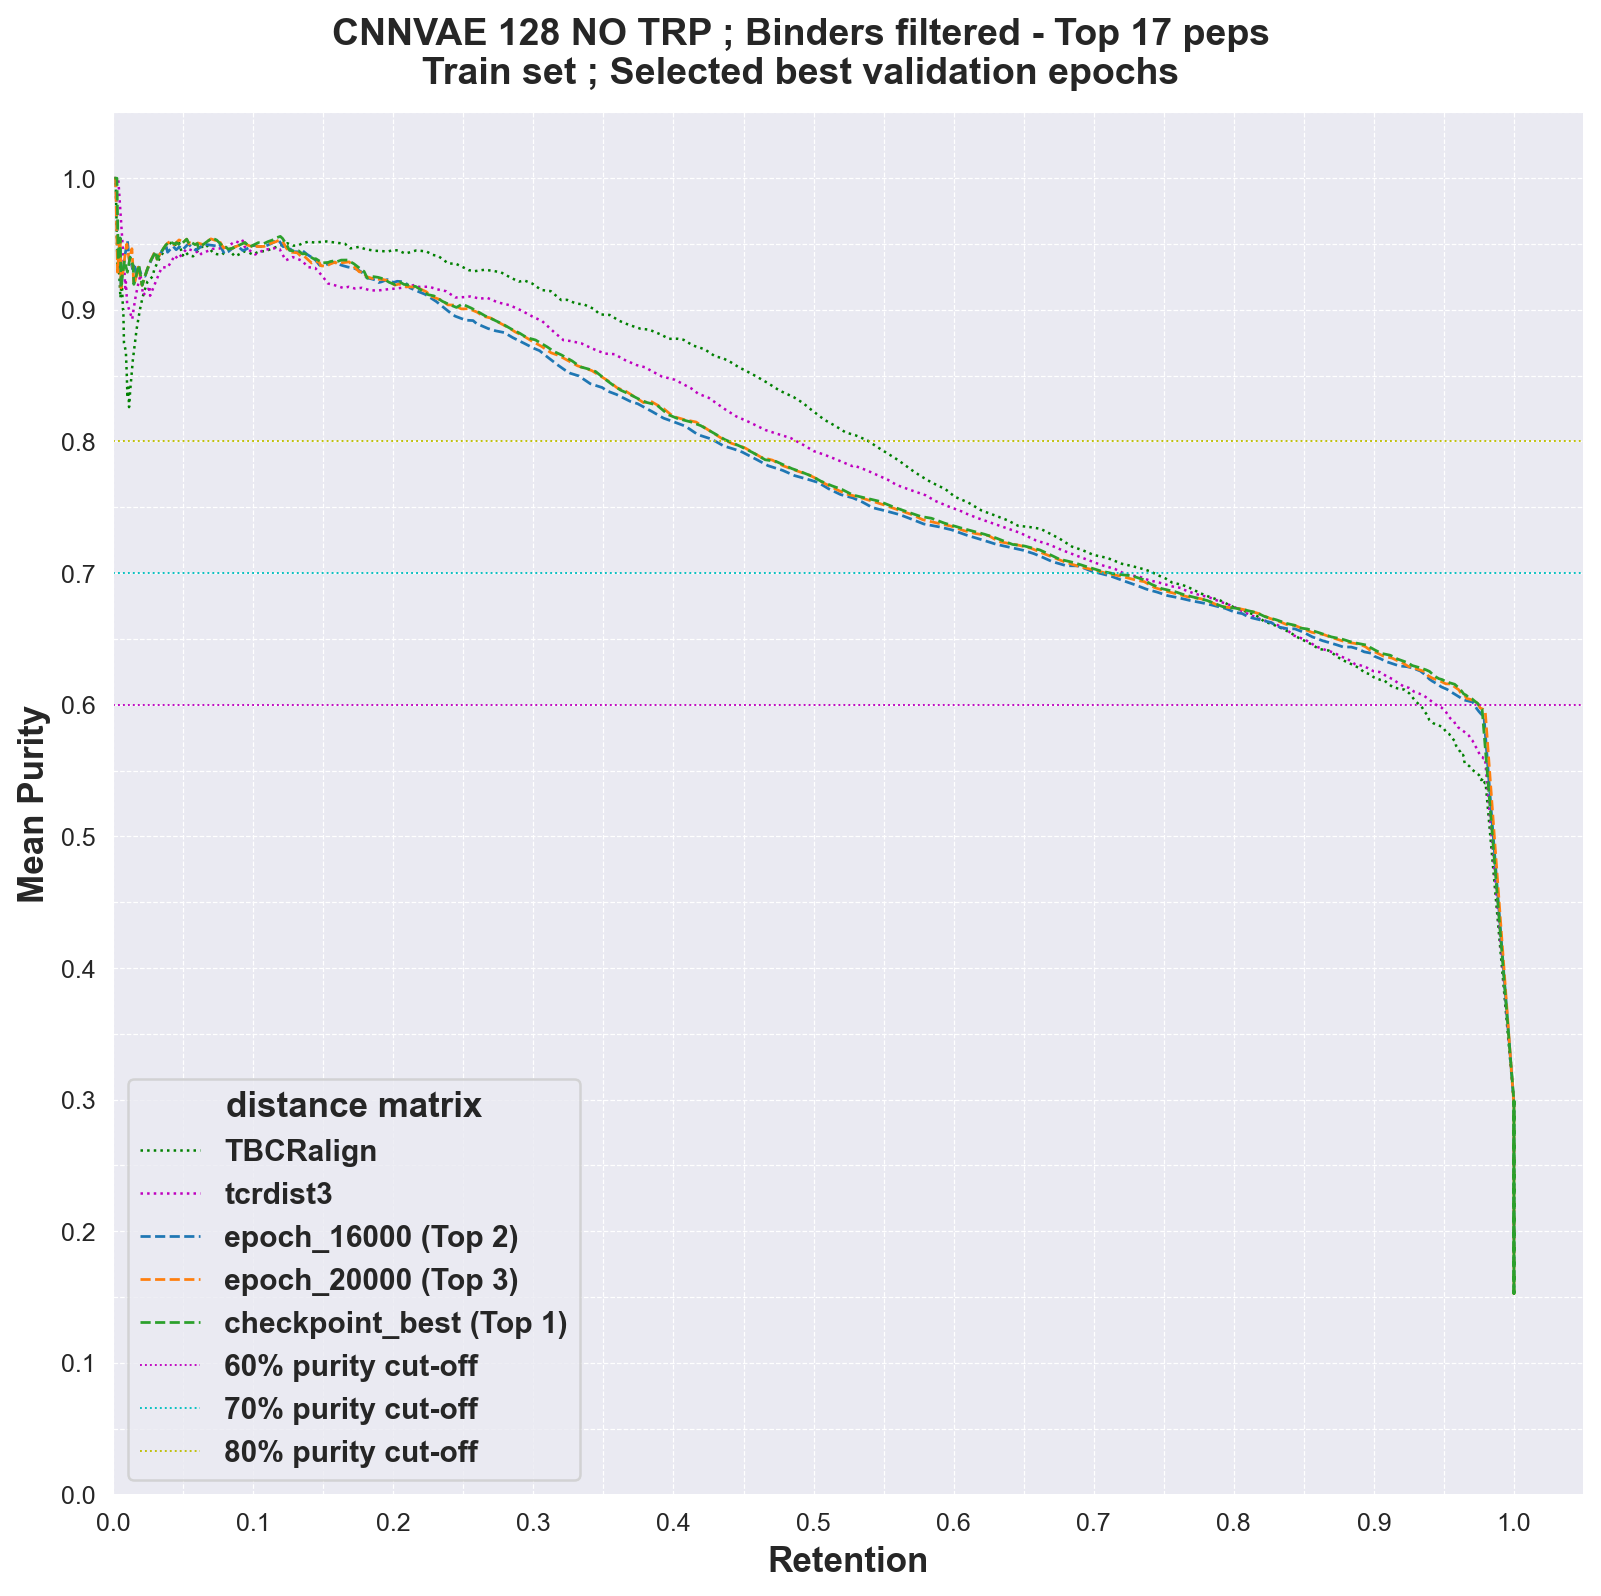

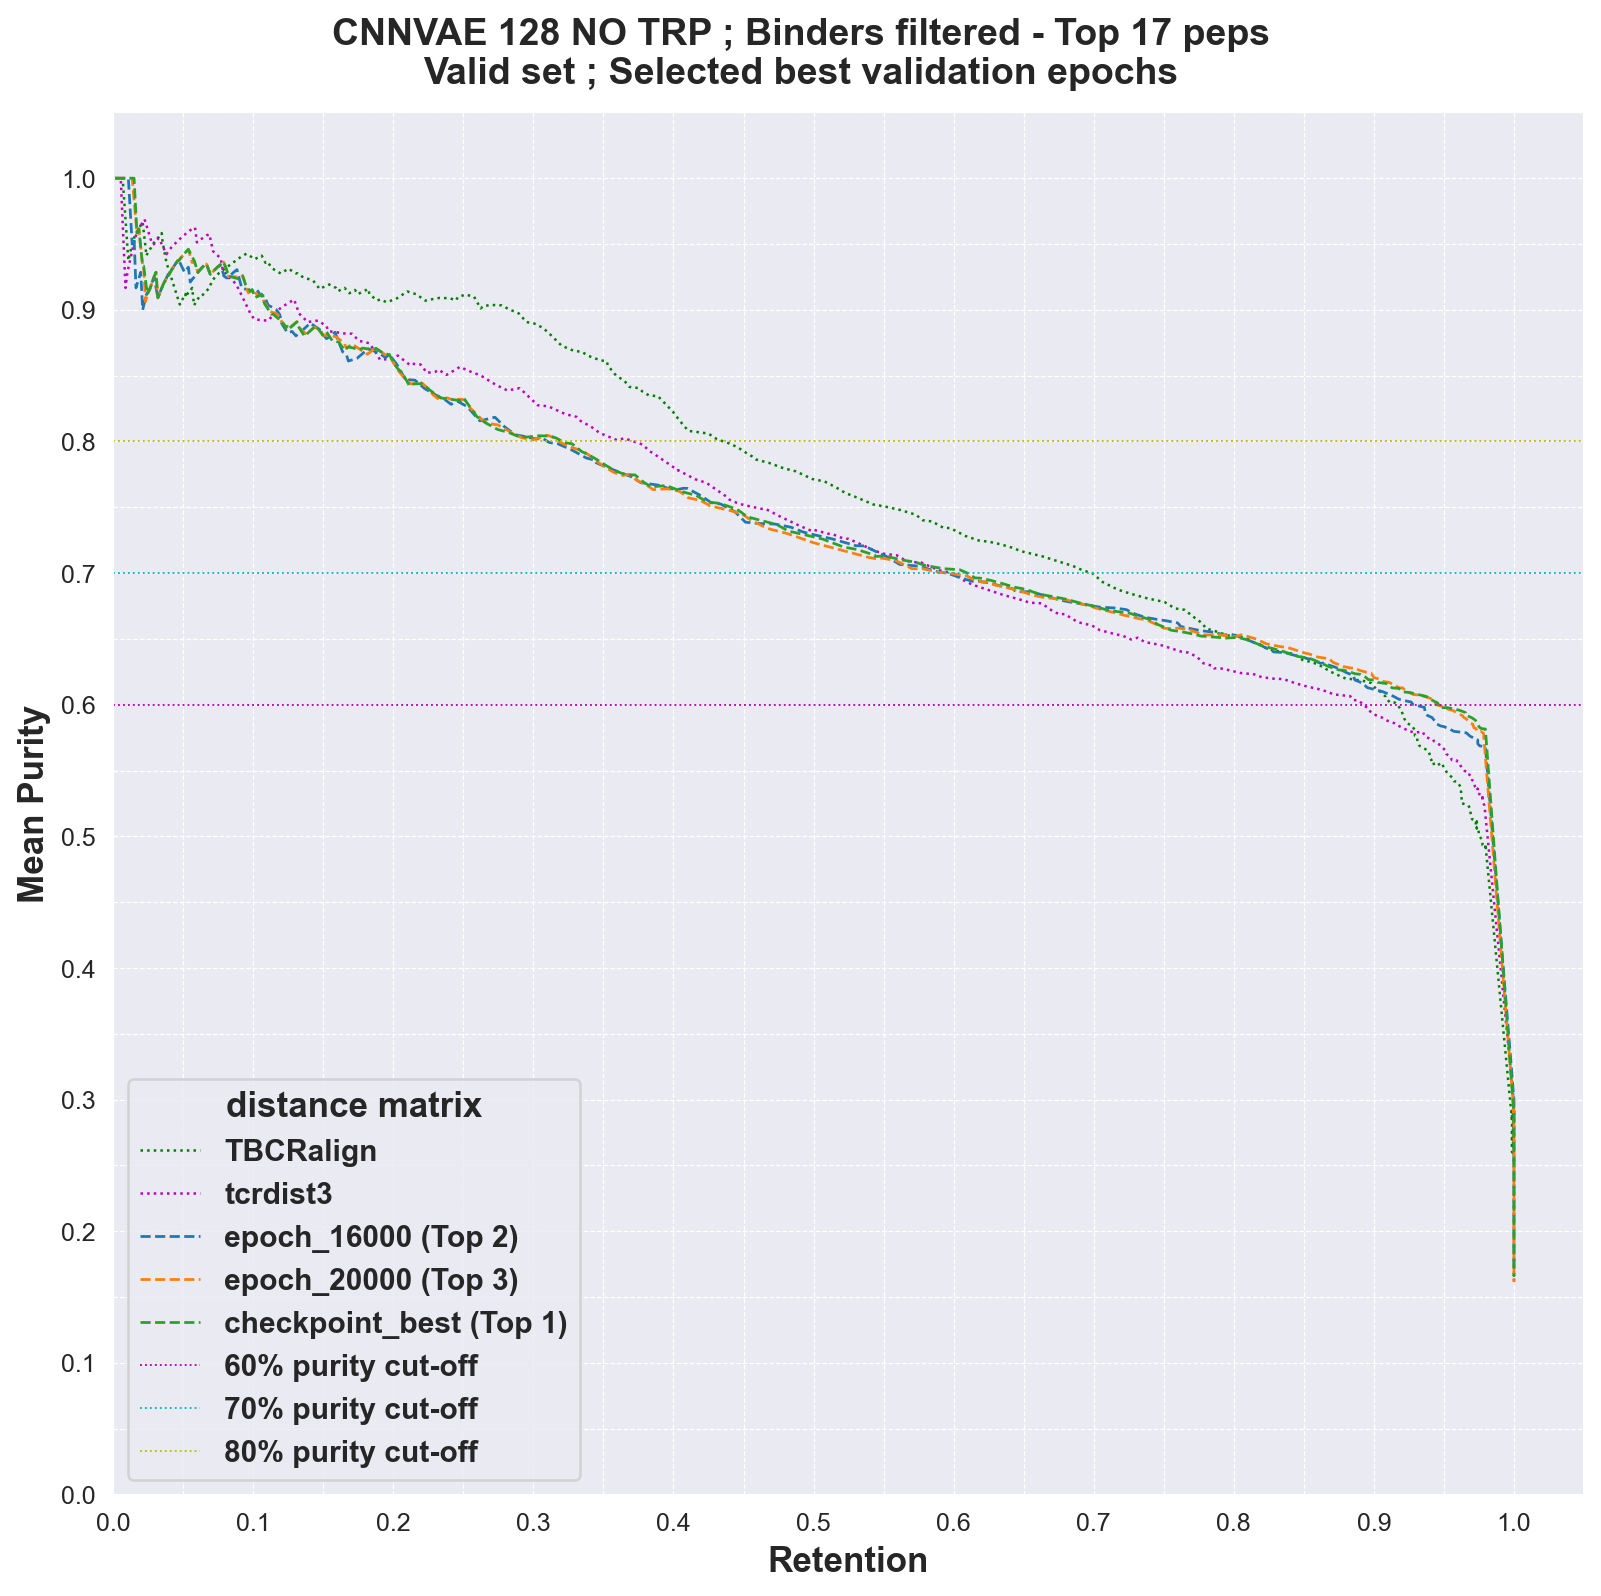

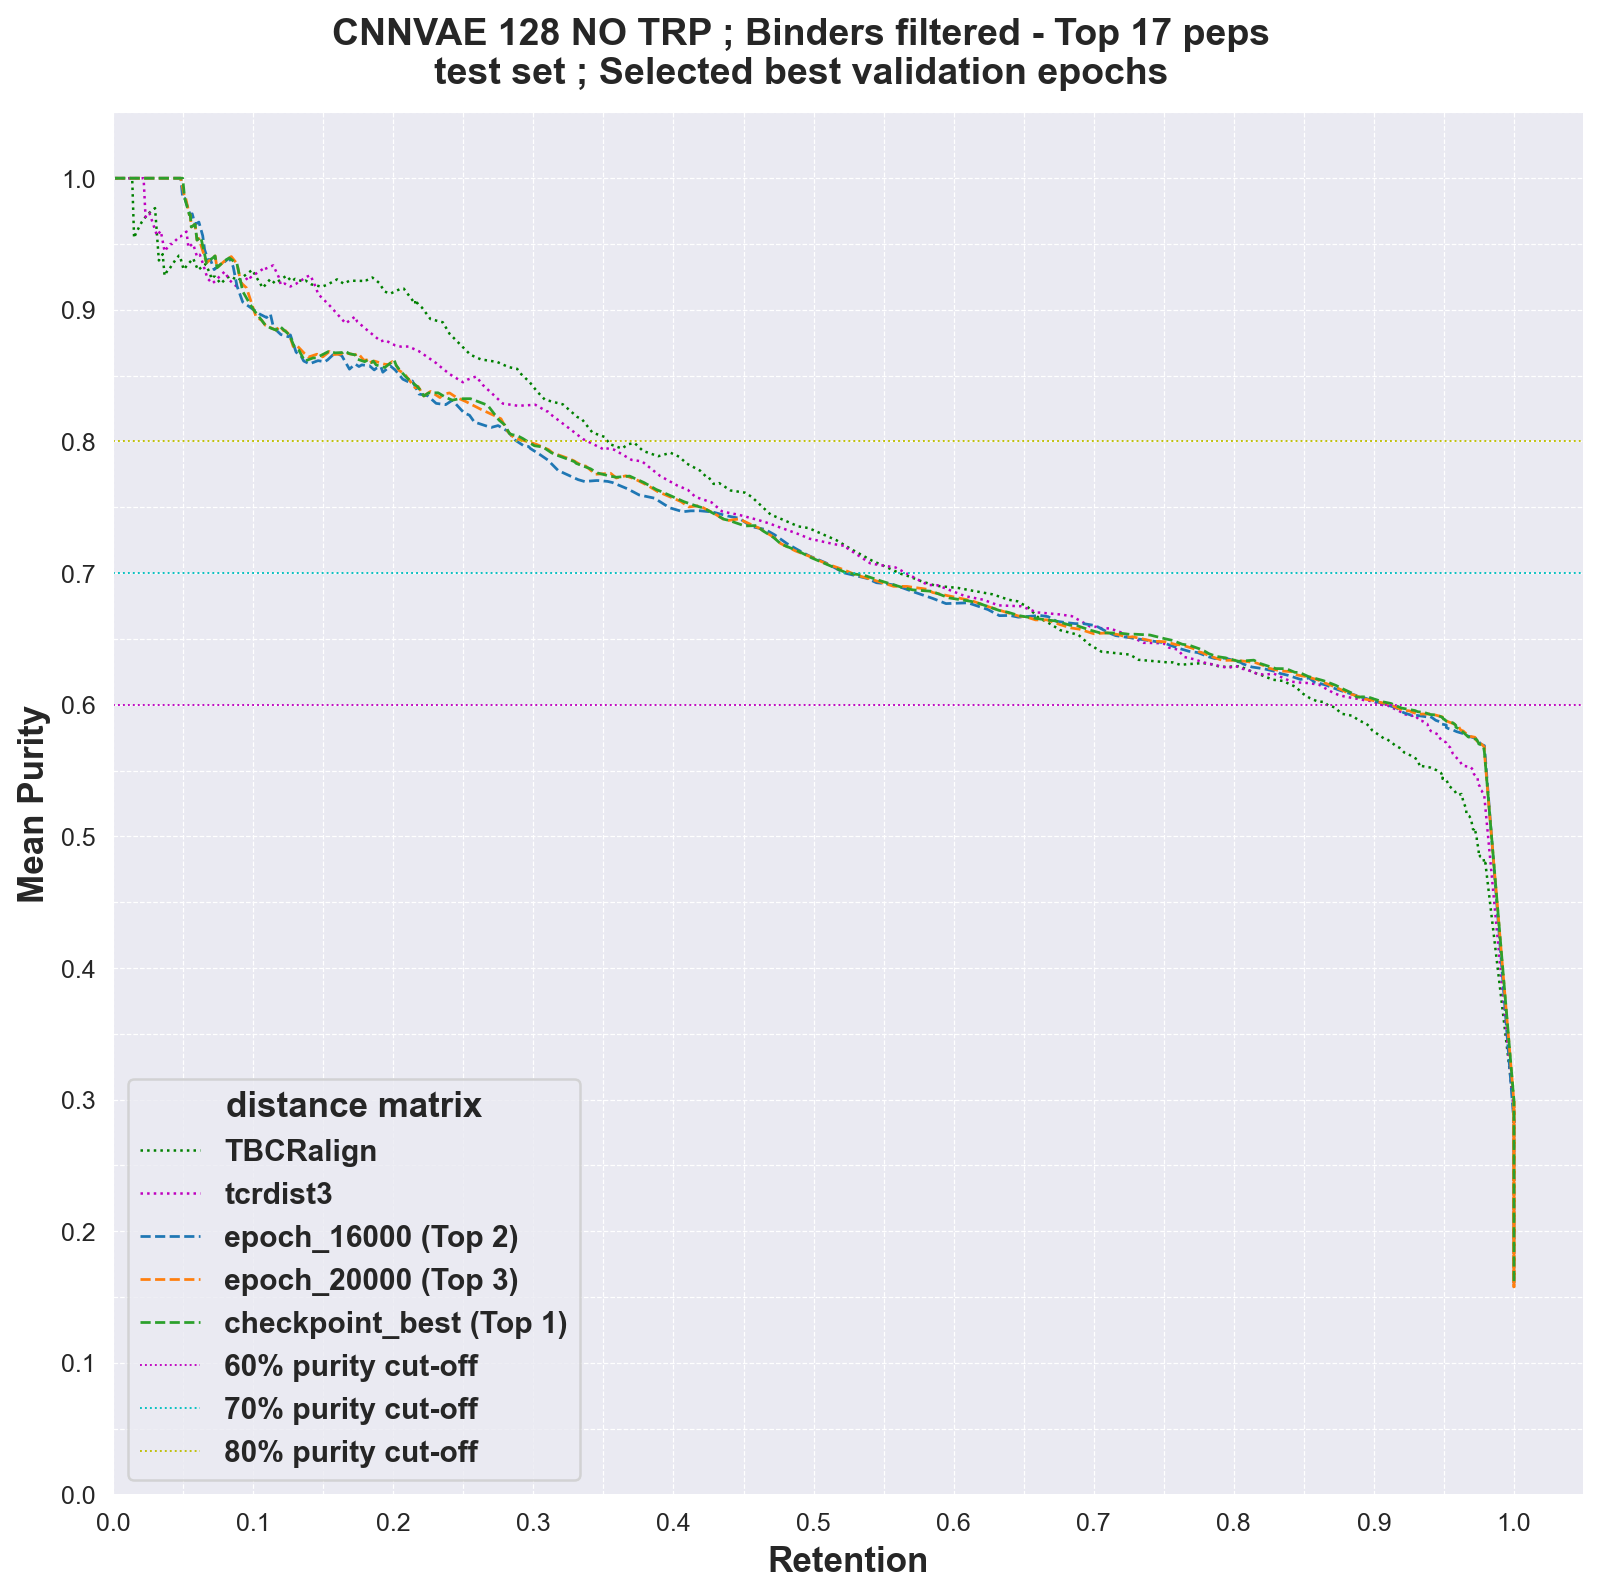

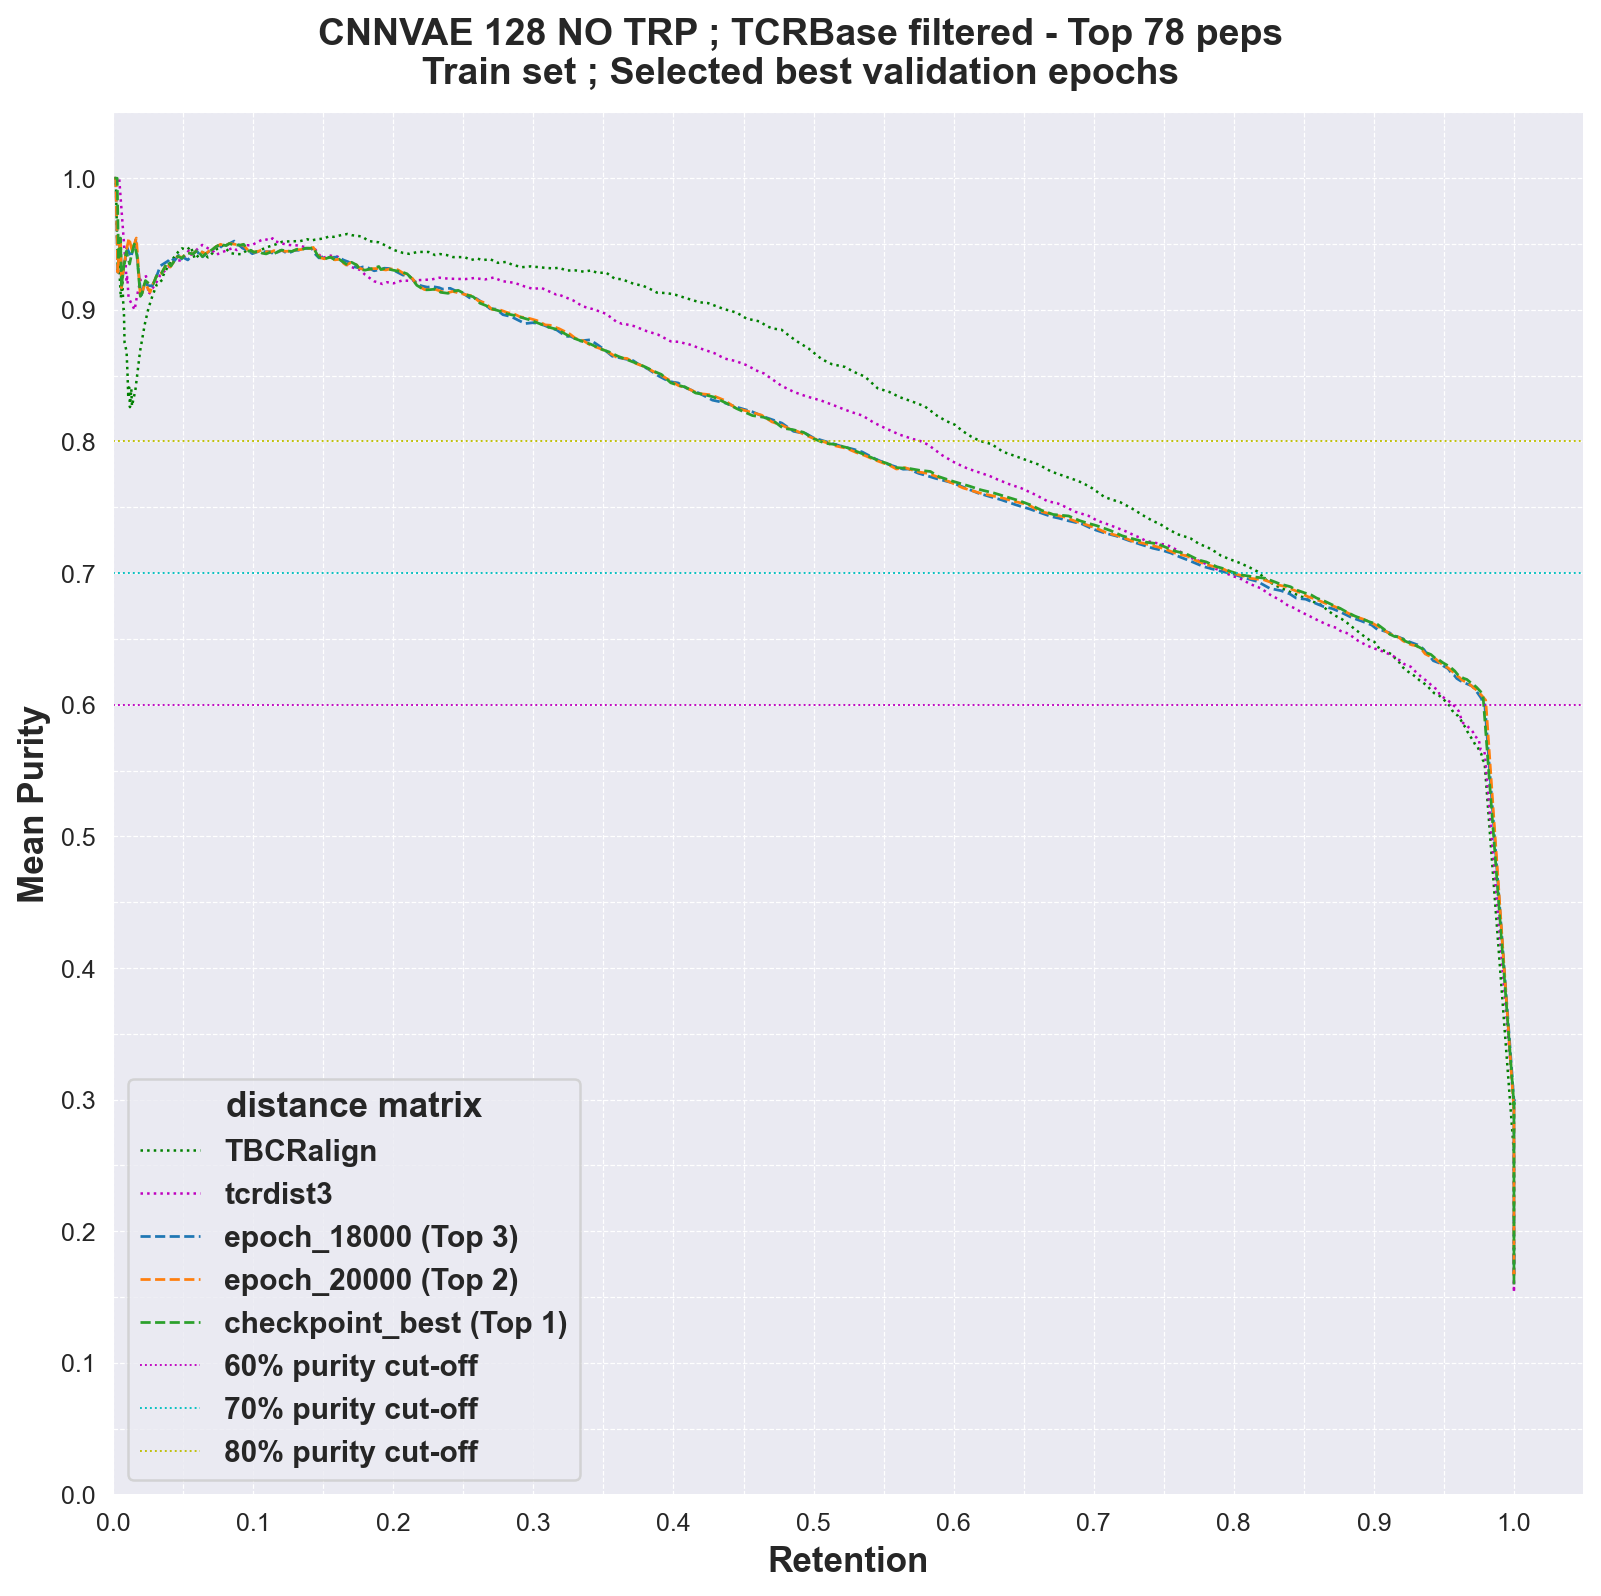

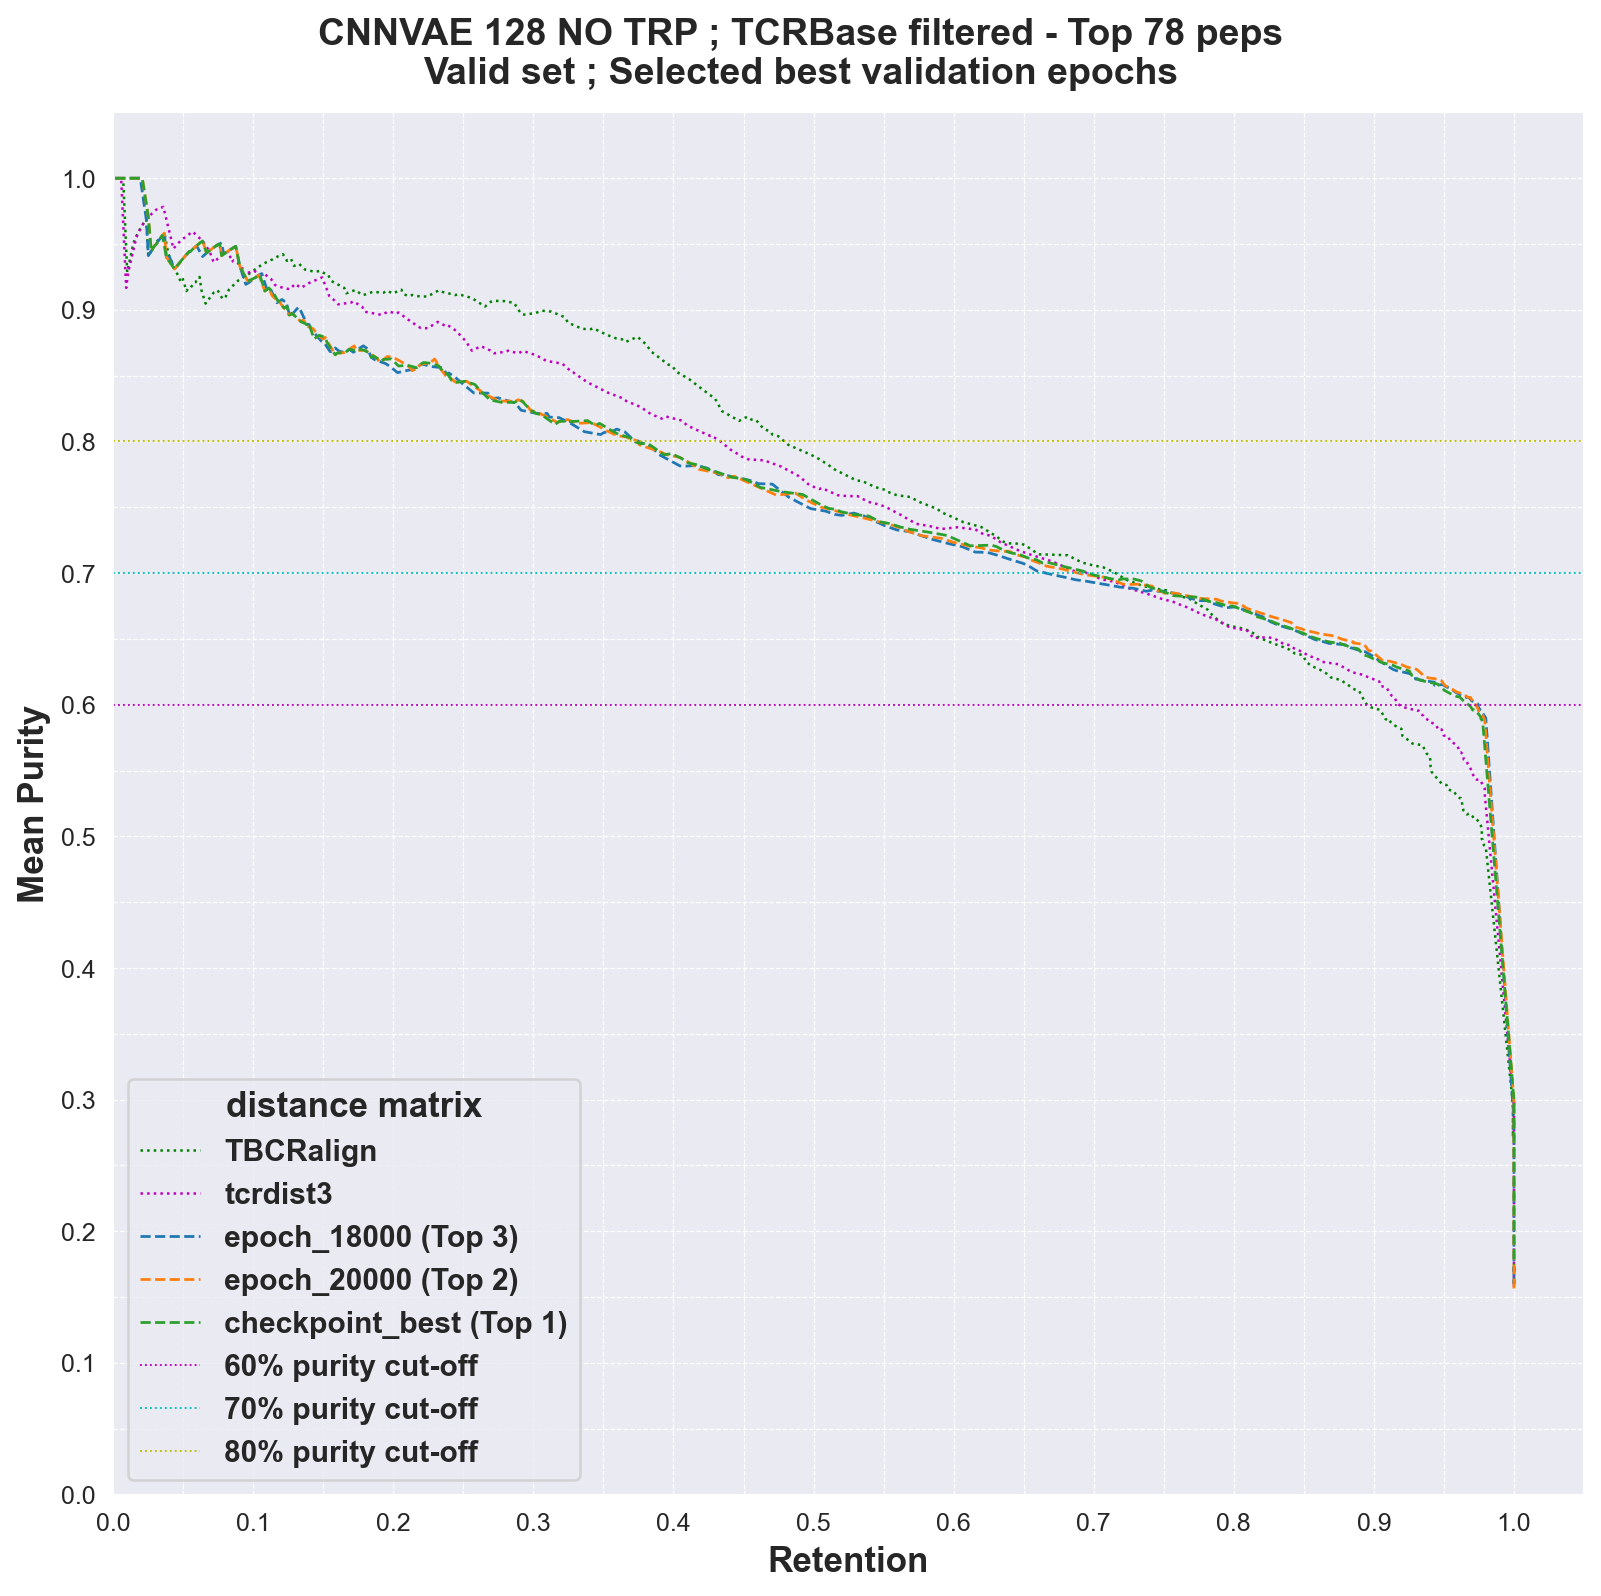

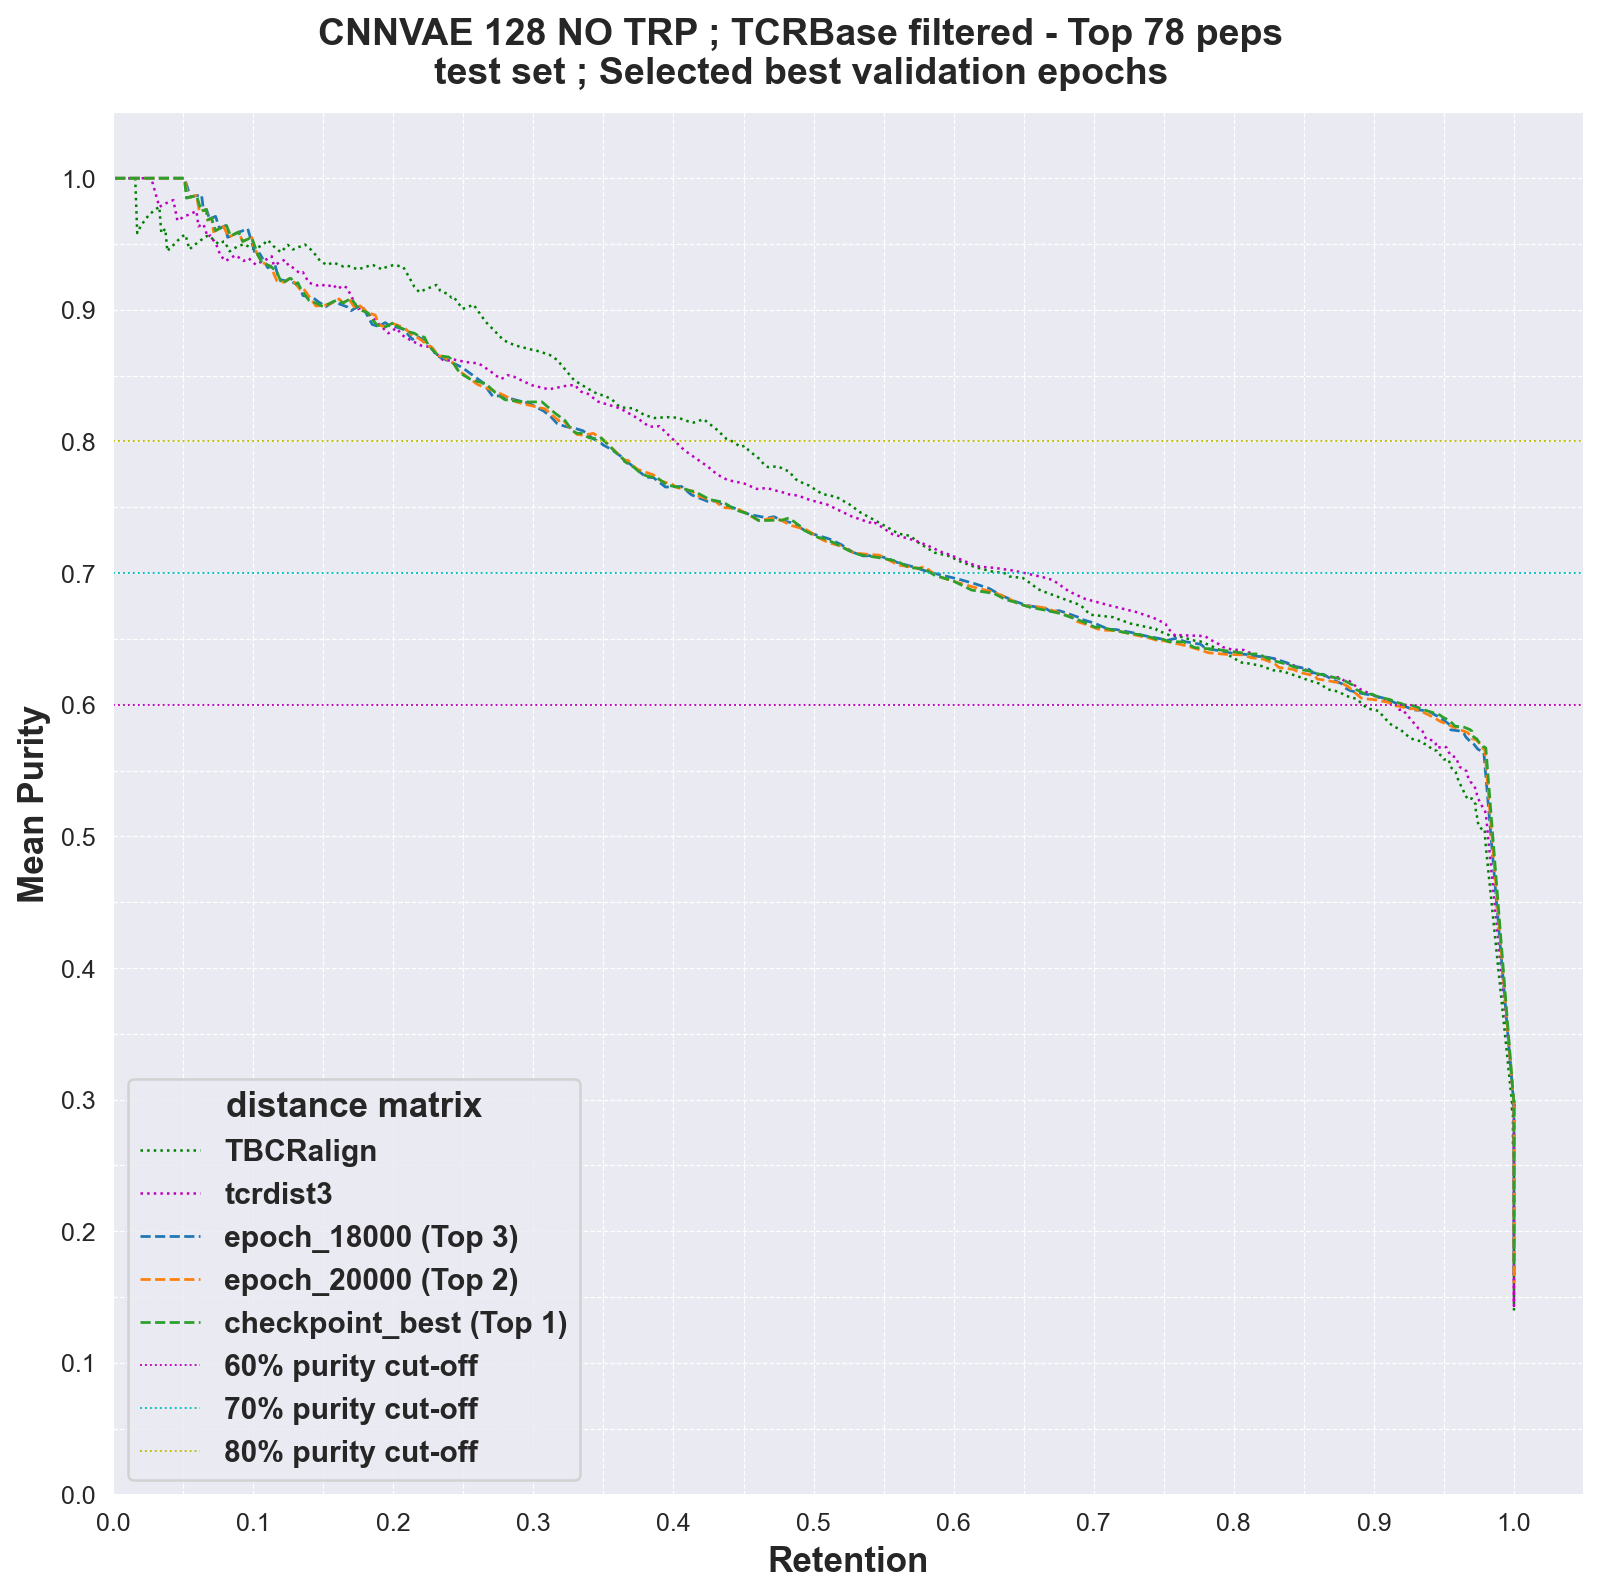

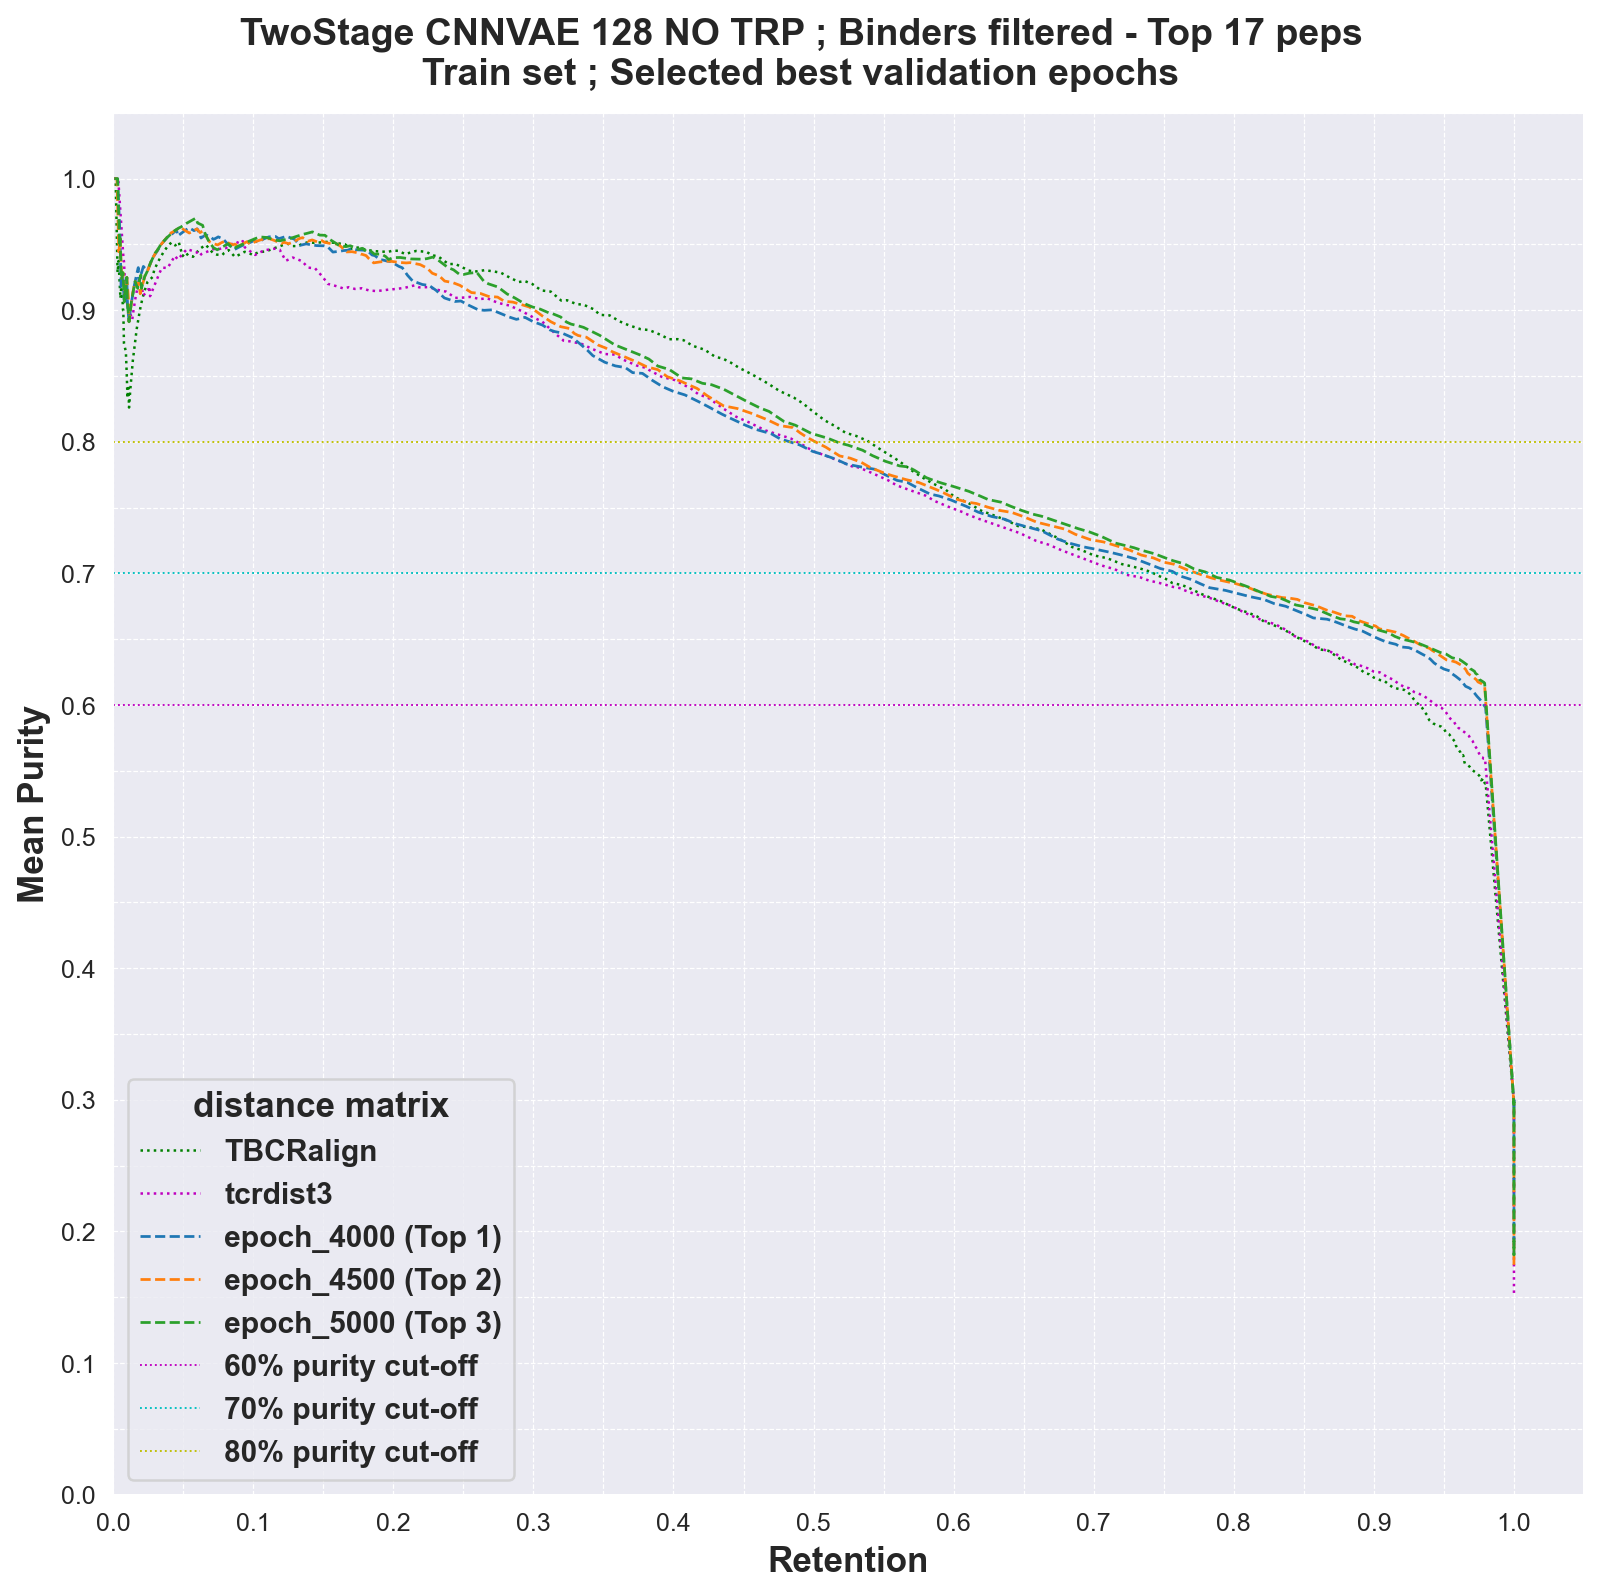

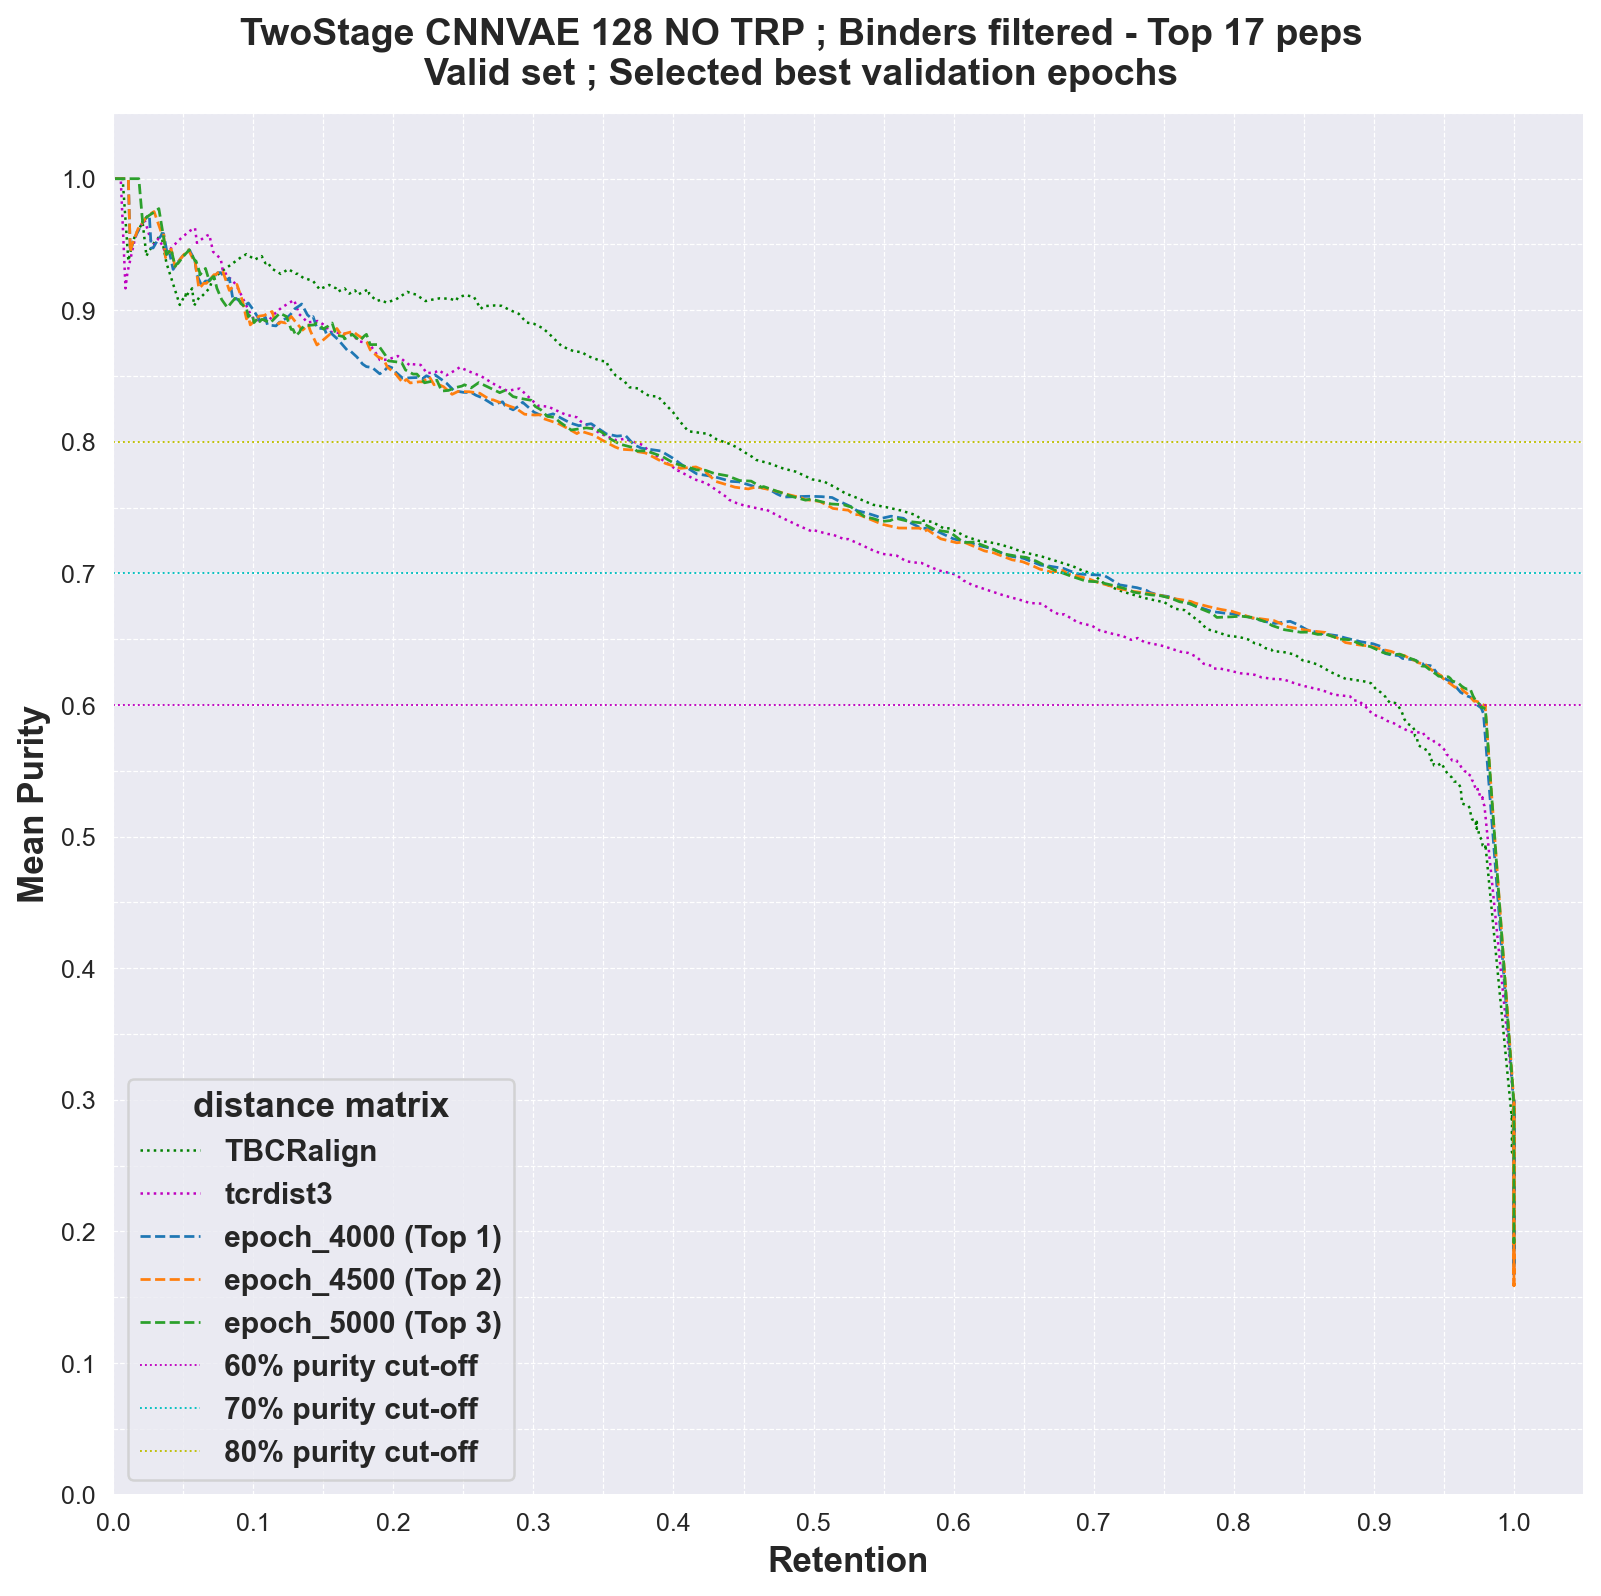

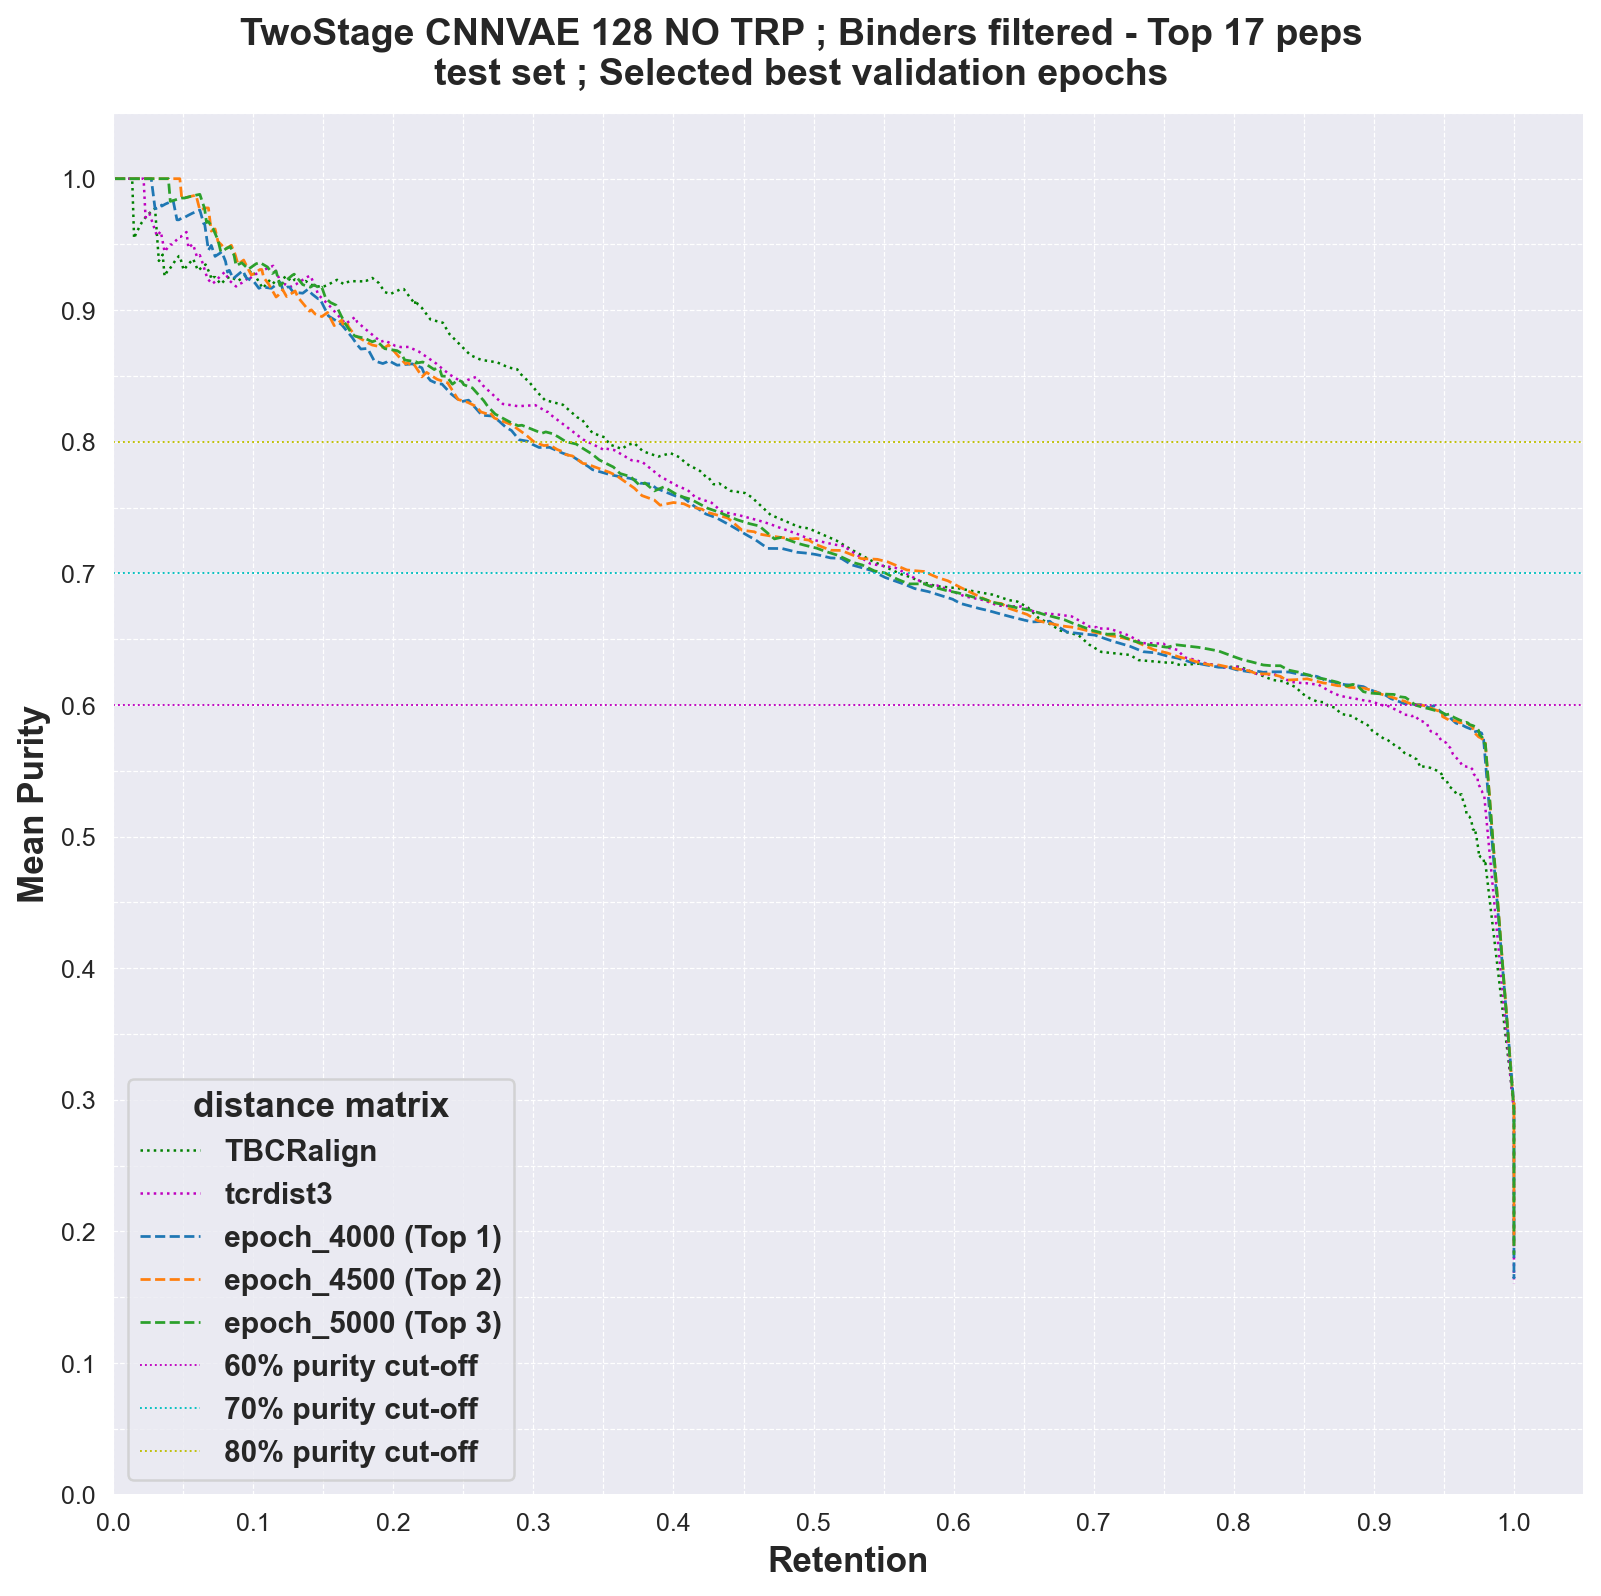

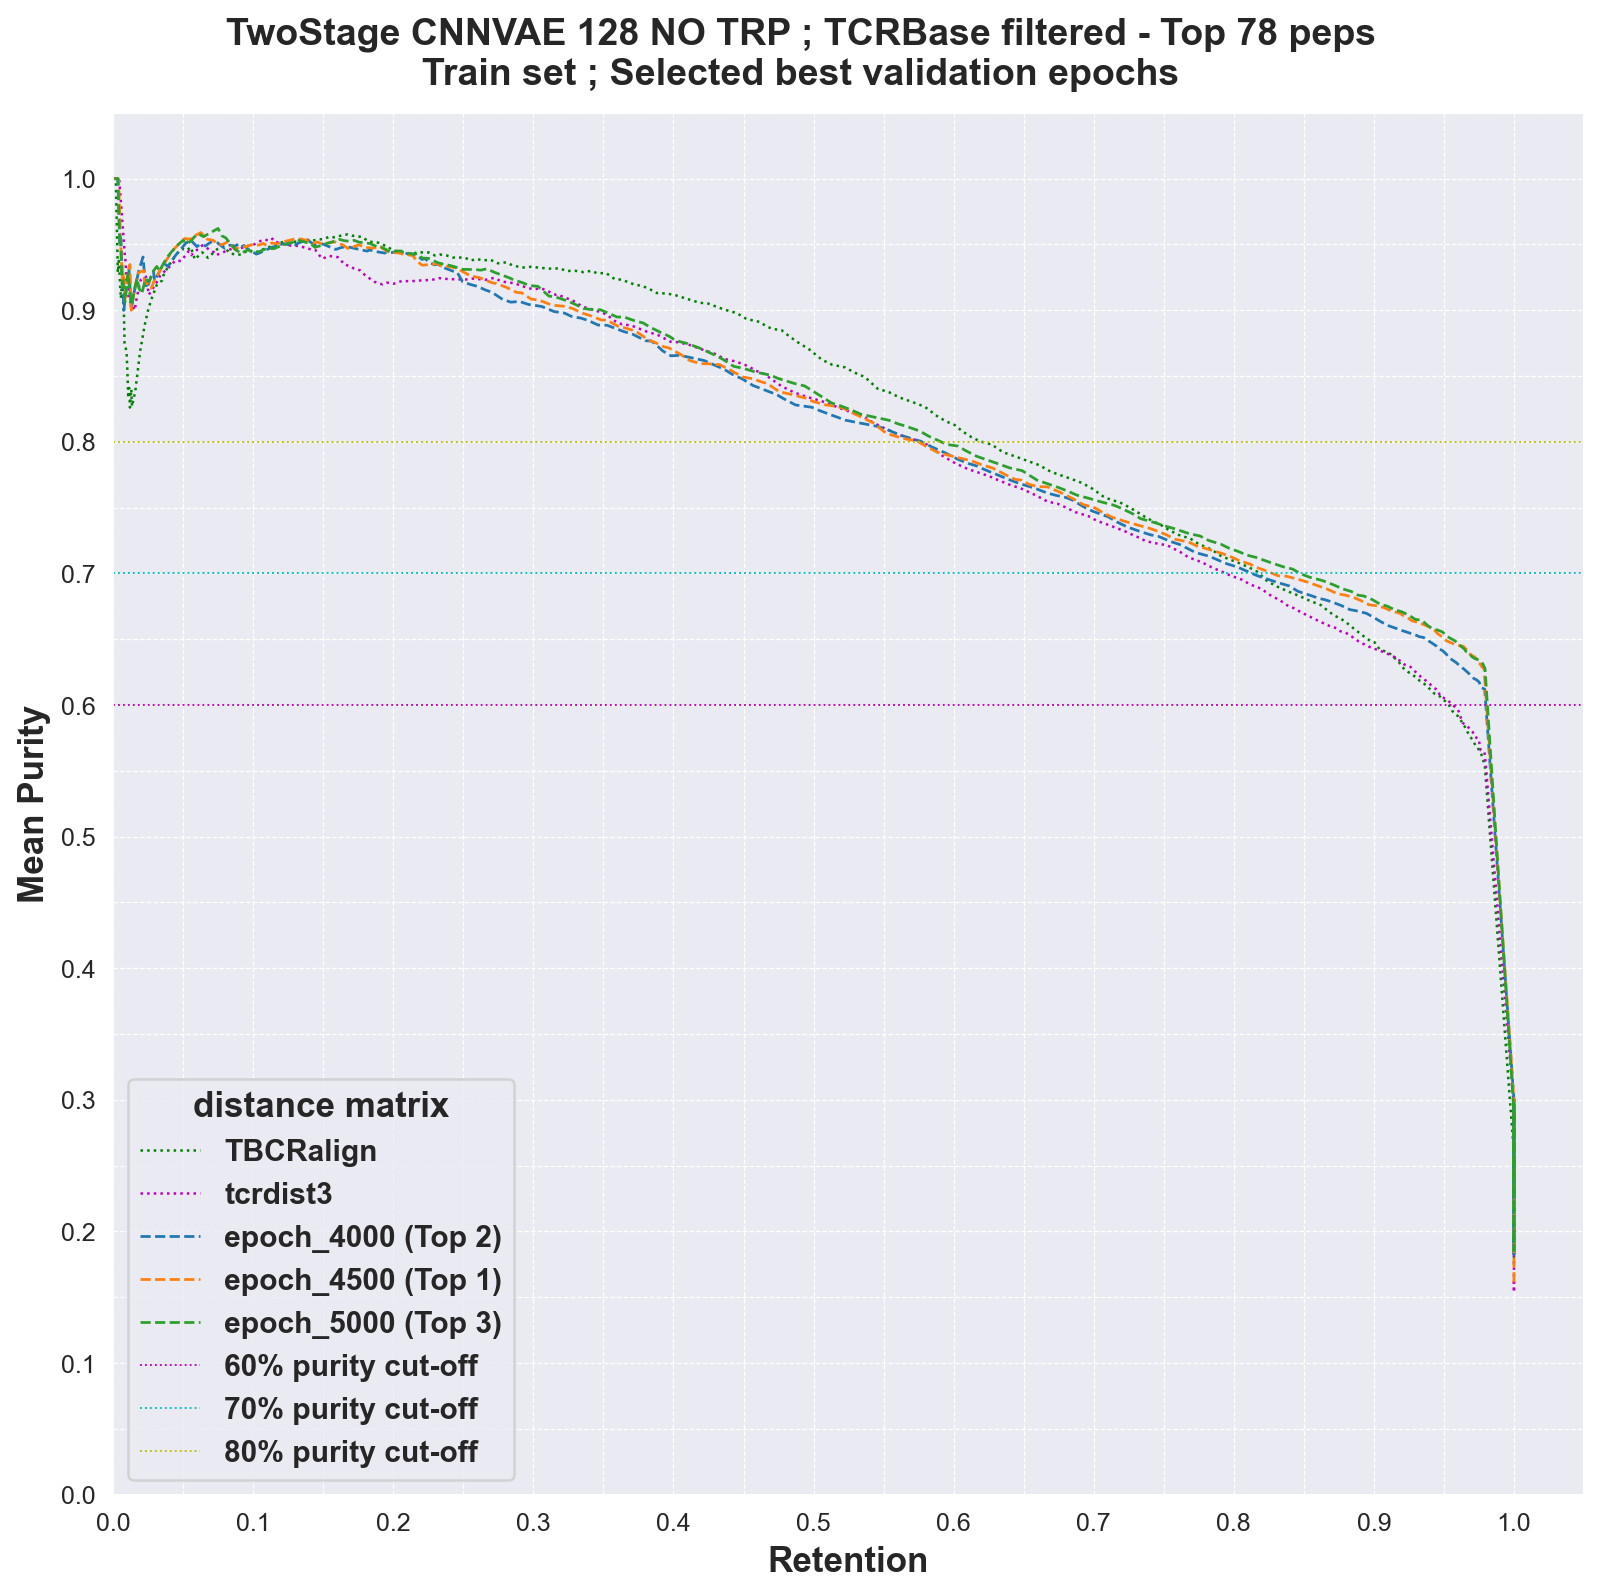

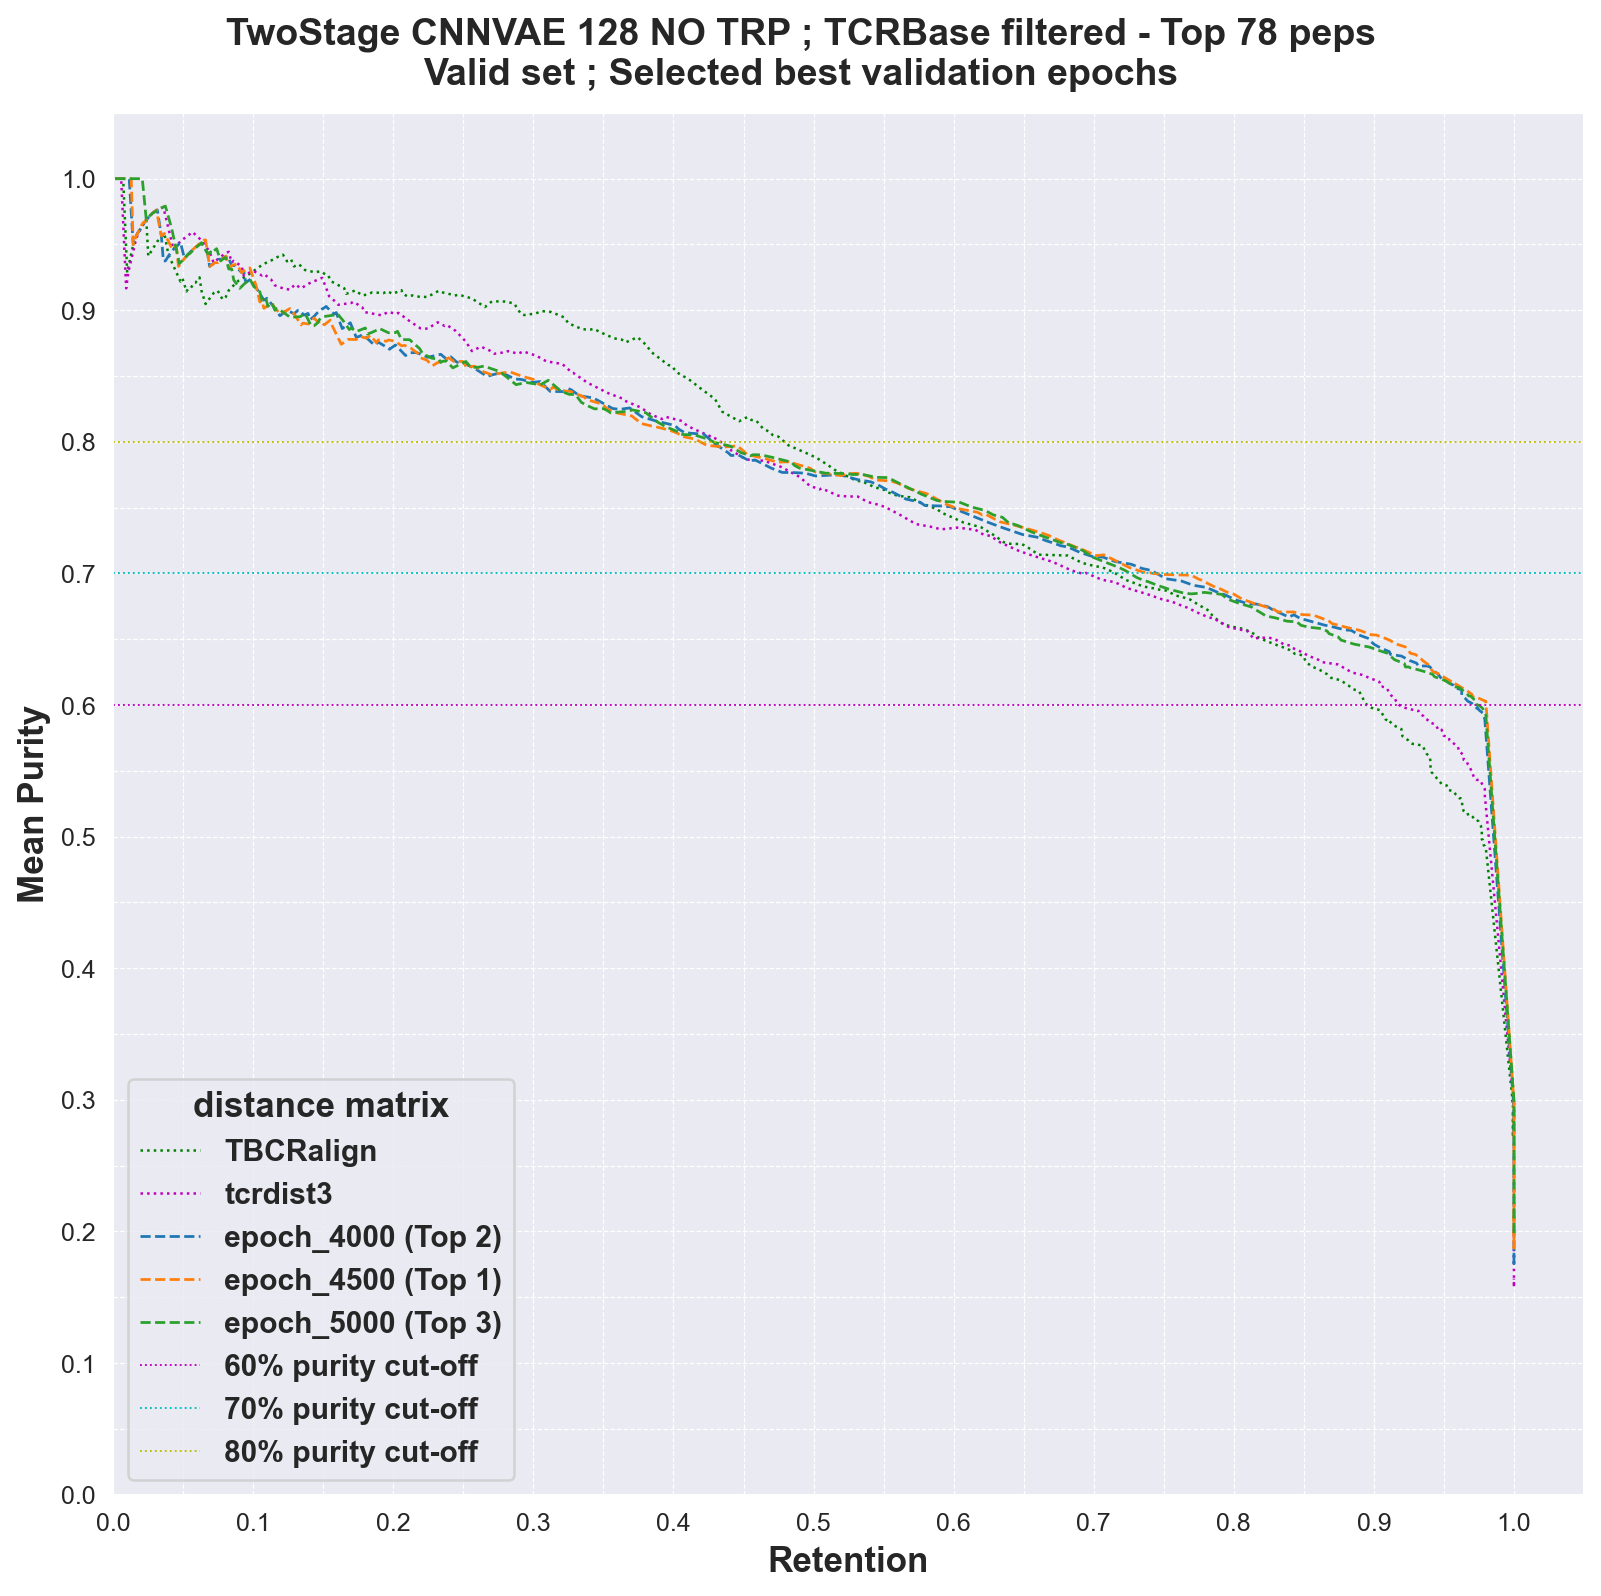

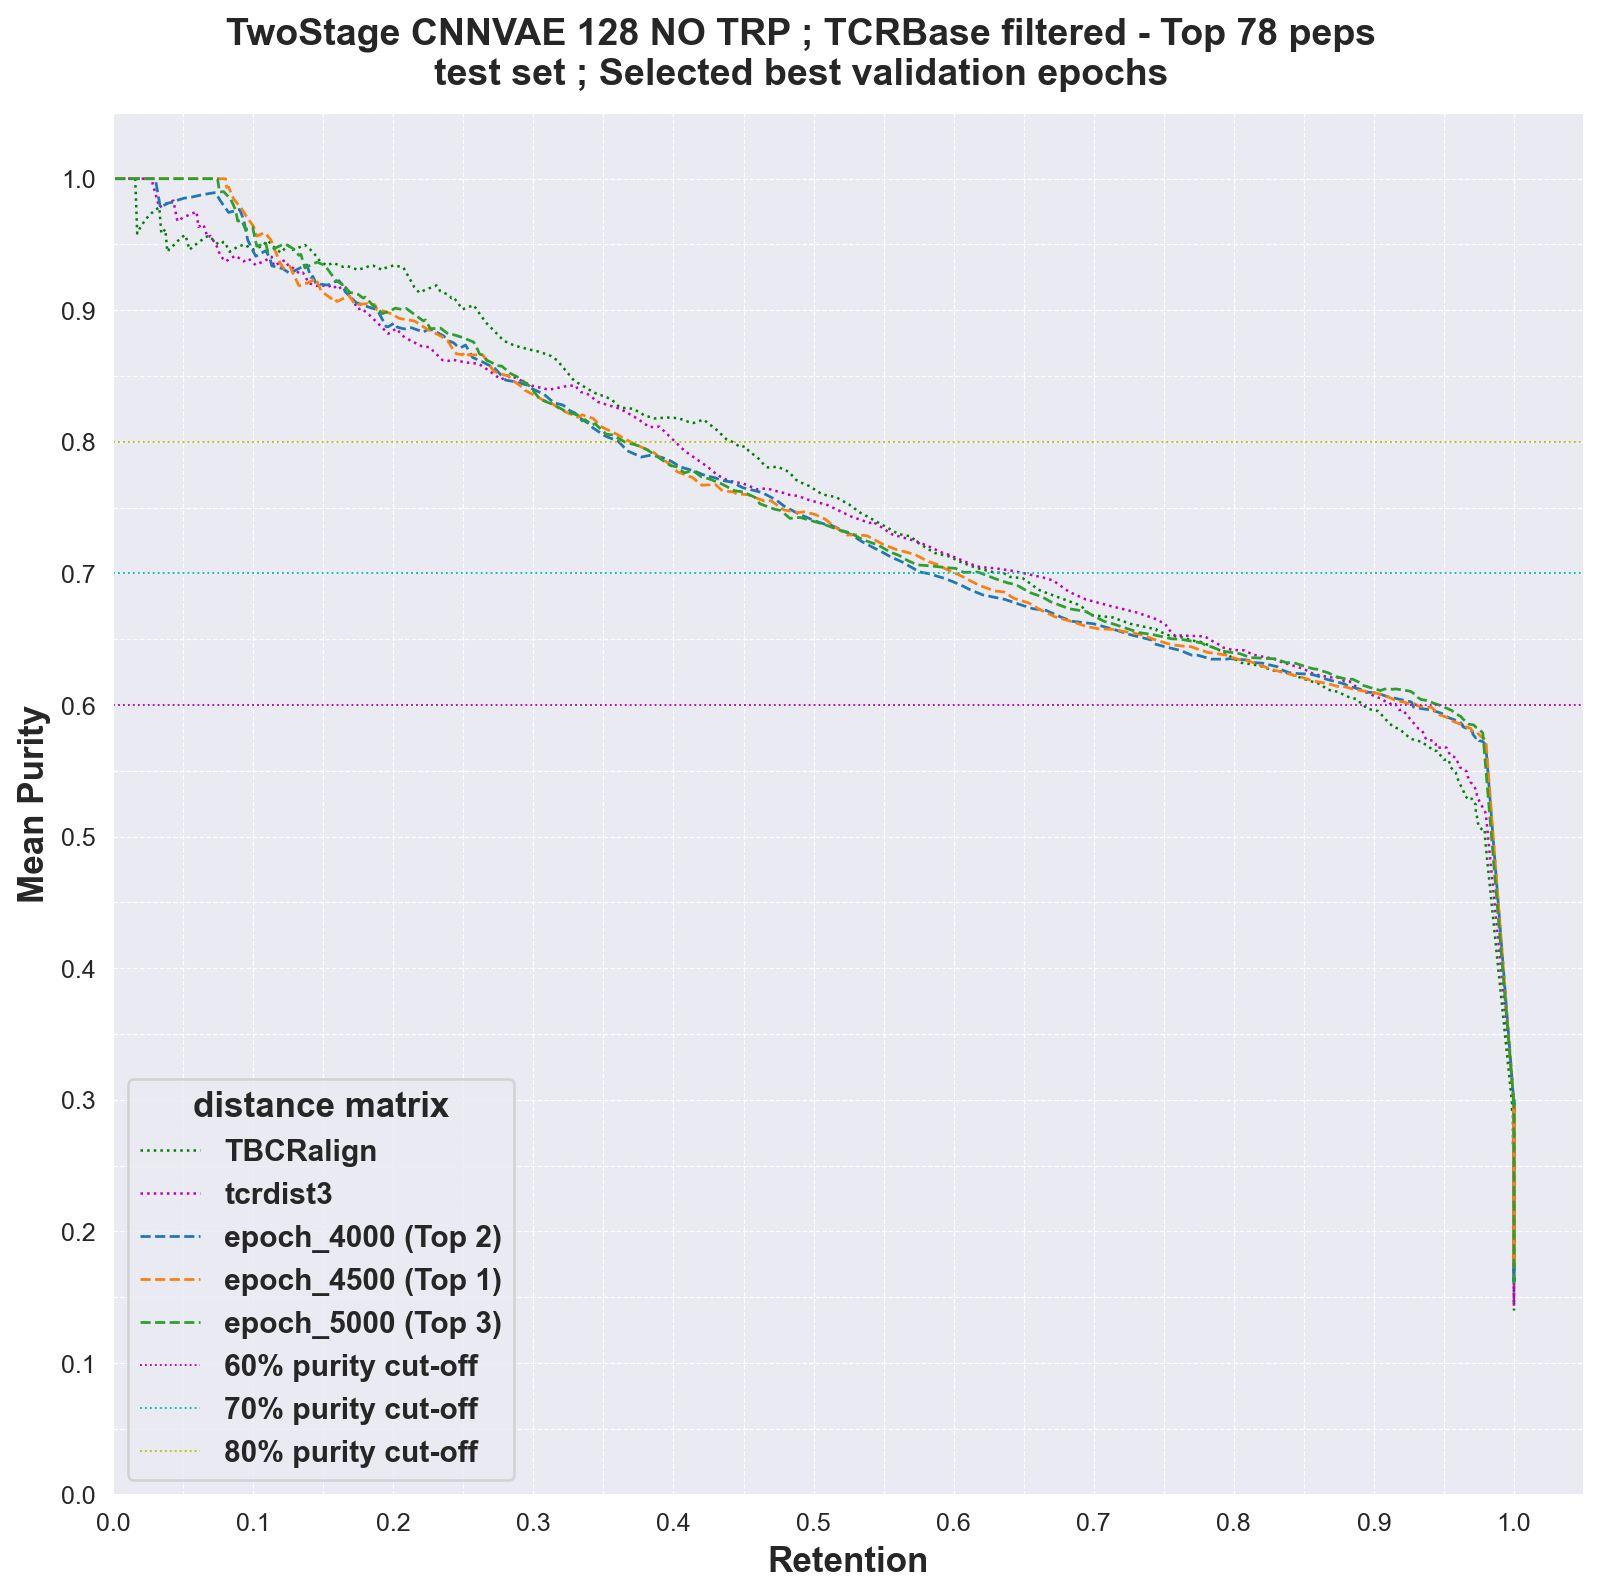

In [5]:
names = ['CNNVAE 128 NO TRP ; Binders filtered - Top 17 peps',
         'CNNVAE 128 NO TRP ; TCRBase filtered - Top 78 peps',
         'TwoStage CNNVAE 128 NO TRP ; Binders filtered - Top 17 peps',
         'TwoStage CNNVAE 128 NO TRP ; TCRBase filtered - Top 78 peps']
filenames = ['CNNVAE_128_Top17peps_NoTrp', 
             'CNNVAE_128_Top78peps_NoTrp', 
             'TwoStage_128_Top17peps_NoTrp', 
             'TwoStage_128_Top78peps_NoTrp']
files = sorted(glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*NOTRIPLET*/'))

for name, filename, main_folder in zip(names, filenames, files):
    results_pipeline(main_folder, title=name, fn=filename, outdir='../output/240618_NestedKCV_CNNVAE/figs/')

# TCRbase detour

In [6]:
exp_swap = pd.read_csv('../data/filtered/240326_nettcr_exp_paired_withswaps.csv')
old_swap = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')

In [7]:
from sklearn.metrics import roc_auc_score
from src.metrics import get_metrics
def read_tcrbase_results(peptide, original_df, partition=0, dir='../output/TCRBASE/tcrbase_expanded_ALL_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}_p{partition}.txt', comment='#', sep='\s', header=None, names=cols)
    df['q_seq'] = df['q_A1']+df['q_A2']+df['q_A3']+df['q_B1']+df['q_B2']+df['q_B3']
    original_df = original_df.query('peptide==@peptide and partition==@partition')
    original_df['q_seq'] = original_df['A1']+original_df['A2']+original_df['A3']+original_df['B1']+original_df['B2']+original_df['B3']
    results = pd.merge(df.set_index('q_seq')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df.set_index('q_seq')[['partition','binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==@partition'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
        

In [8]:
total_exp=[]
total_old=[]
for partition in range(5):
    exp_results = []
    for p in exp_swap.peptide.unique():
        x, _ = read_tcrbase_results(p, exp_swap, partition=partition, dir='../output/TCRBASE/tcrbase_expanded_ALL_swapped/')
        exp_results.append(x)    
    exp_results = pd.DataFrame(exp_results)
    
    old_results = []
    for p in old_swap.peptide.unique():
        x, _ = read_tcrbase_results(p, old_swap, partition=partition, dir='../output/TCRBASE/tcrbase_old_ALL_swapped/')
        old_results.append(x)    
    old_results = pd.DataFrame(old_results)
    total_exp.append(exp_results.assign(partition=partition))
    total_old.append(old_results.assign(partition=partition))
    exp_results.sort_values('n_pos', ascending=False).to_csv(f'../output/TCRBASE/results_exp_partition_p{partition}.csv', index=False)
    old_results.sort_values('n_pos', ascending=False).to_csv(f'../output/TCRBASE/results_old_partition_p{partition}.csv', index=False)

AVFDRKSDAK 0.4855
{'peptide': 'AVFDRKSDAK', 'method': 'tcrbase', 'n_pos': 143, 'auc': 0.48551, 'auc_01': 0.50745, 'auc_01_real': 0.06416, 'precision': 0.16628, 'recall': 1.0, 'accuracy': 0.16628, 'AP': 0.18505}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 181, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 92, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
TTDPSFLGRY 0.6819
{'peptide': 'TTDPSFLGRY', 'method': 'tcrbase', 'n_pos': 78, 'auc': 0.68187, 'auc_01': 0.61969, 'auc_01_real': 0.27741, 'precision': 0.16774, 'recall': 1.0, 'accuracy': 0.16774, 'AP': 0.44064}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 166, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recal

In [9]:
pd.concat(total_exp).drop(columns=['method']).groupby('peptide').mean().sort_values('n_pos',ascending=False).to_csv(f'../output/TCRBASE/total_mean_exp_results.csv', index=True)
pd.concat(total_old).drop(columns=['method']).groupby('peptide').mean().sort_values('n_pos',ascending=False).to_csv(f'../output/TCRBASE/total_mean_old_results.csv', index=True)

In [10]:
total_exp = pd.concat(total_exp).drop(columns=['method']).groupby('peptide').mean()
total_old = pd.concat(total_old).drop(columns=['method']).groupby('peptide').mean()

In [11]:
exp_filt = total_exp.query('n_pos>=75').sort_values('auc',ascending=False).head(17).index
total_exp.query('n_pos>75').sort_values('auc',ascending=False).head(17).sort_index()


n_pos       auc    auc_01  auc_01_real  precision  recall  \
peptide                                                                 
AVFDRKSDAK  143.4  0.537760  0.523512     0.094672   0.166668     1.0   
ELAGIGILTV   91.4  0.913552  0.809742     0.638514   0.166668     1.0   
GILGFVFTL   233.0  0.829168  0.744974     0.515450   0.166670     1.0   
KLGGALQAK   180.2  0.583082  0.561664     0.167164   0.166664     1.0   
RAKFKQLL    166.0  0.901230  0.833696     0.684024   0.166670     1.0   
SPRWYFYYL    89.8  0.671422  0.649950     0.334904   0.166670     1.0   
TTDPSFLGRY   77.4  0.672200  0.632344     0.301454   0.166666     1.0   
YLQPRTFLL    79.8  0.731442  0.694864     0.420246   0.166662     1.0   

            accuracy        AP  partition  
peptide                                    
AVFDRKSDAK  0.166668  0.216992        2.0  
ELAGIGILTV  0.166668  0.782364        2.0  
GILGFVFTL   0.166670  0.634484        2.0  
KLGGALQAK   0.166664  0.289294        2.0  
RAKFKQLL    0.166670  0.779796        2.0  
SPRWYFYYL   0.166670  0.475666        2.0  
TTDPSFLGRY  0.166666  0.458376        2.0  
YLQPRTFLL   0.166662  0.573052        2.0

# inits

In [18]:
exp_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
exp78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
exp17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
old15 = pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv')
old20 = pd.read_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')

In [19]:
sample = exp_df.sample(n=15).to_csv('../data/15seqs_test.csv', index=False)

In [13]:
def get_agg_matrix(dm_vae, dm_base, index_col='raw_index', cols = ('peptide', 'original_peptide','raw_index', 'binder', 'partition')):
    if not all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]):
        dm_base, values_base = resort_baseline(dm_base, dm_vae, index_col)
    else:
        values_base = None
    values_vae = dm_vae.iloc[:len(dm_vae), :len(dm_vae)].values
    if values_base is None:
        values_base = dm_base.iloc[:len(dm_base), :len(dm_base)].values
    assert all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]) and len(dm_vae)==len(dm_base)
    agg_values = 1-np.multiply(1-values_vae, 1-values_base)
    agg_dm = pd.DataFrame(agg_values)
    agg_dm[list(cols)] = dm_vae[list(cols)].values
    return agg_dm, agg_dm.iloc[:len(agg_dm), :len(agg_dm)].values

In [14]:
dm_tbcr = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
dm_tcrdist = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0)

In [15]:
model_ts128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
model_os128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
model_os256 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/epoch_8000_interval_checkpoint__fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02_JSON_kwargs.json',
                              map_location='cpu', verbose=False)

model_ts128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/epoch_4000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm.pt',
                                    '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm_JSON_kwargs.json',
                                    map_location='cpu', verbose=False)
model_os128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni.pt',
                                    '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni_JSON_kwargs.json',
                              map_location='cpu', verbose=False)

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 256 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
